In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import keras
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Input, Conv2DTranspose, Concatenate, BatchNormalization, UpSampling2D
from tensorflow.keras.layers import  Dropout, Activation
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.losses import binary_crossentropy, categorical_crossentropy
from tensorflow.keras.utils import plot_model, to_categorical


import glob
import random
import cv2
from random import shuffle

In [ ]:
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
!tar -xvzf images.tar.gz && tar -xvzf annotations.tar.gz
!rm  images/*.mat

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
annotations/trimaps/._pomeranian_180.png
annotations/trimaps/pomeranian_180.png
annotations/trimaps/._pomeranian_181.png
annotations/trimaps/pomeranian_181.png
annotations/trimaps/._pomeranian_182.png
annotations/trimaps/pomeranian_182.png
annotations/trimaps/._pomeranian_183.png
annotations/trimaps/pomeranian_183.png
annotations/trimaps/._pomeranian_184.png
annotations/trimaps/pomeranian_184.png
annotations/trimaps/._pomeranian_185.png
annotations/trimaps/pomeranian_185.png
annotations/trimaps/._pomeranian_186.png
annotations/trimaps/pomeranian_186.png
annotations/trimaps/._pomeranian_187.png
annotations/trimaps/pomeranian_187.png
annotations/trimaps/._pomeranian_188.png
annotations/trimaps/pomeranian_188.png
annotations/trimaps/._pomeranian_189.png
annotations/trimaps/pomeranian_189.png
annotations/trimaps/._pomeranian_19.png
annotations/trimaps/pomeranian_19.png
annotations/trimaps/._pomeranian_190.png
annotations/trimaps/pomeranian_190.png
annota

In [ ]:
def image_generator(files, batch_size = 32, sz = (256, 256)):
  
  while True: 
    
    #extract a random batch 
    batch = np.random.choice(files, size = batch_size)    
    
    #variables for collecting batches of inputs and outputs 
    batch_x = []
    batch_y = []
    
    for f in batch:

        #get the masks. Note that masks are png files 
        mask = Image.open(f'annotations/trimaps/{f[:-4]}.png')
        mask = np.array(mask.resize(sz))

        #preprocess the mask 
        mask[mask >= 2] = 0 
        mask[mask != 0 ] = 1
        
        batch_y.append(mask)

        #preprocess the raw images 
        raw = Image.open(f'images/{f}')
        raw = raw.resize(sz)
        raw = np.array(raw)

        #check the number of channels because some of the images are RGBA or GRAY
        if len(raw.shape) == 2:
          raw = np.stack((raw,)*3, axis=-1)

        else:
          raw = raw[:,:,0:3]

        batch_x.append(raw)

    #preprocess a batch of images and masks 
    batch_x = np.array(batch_x)/255.
    batch_y = np.array(batch_y)
    # (20, 256, 256)
    # batch_y = np.expand_dims(batch_y,3)
    # (20, 256, 256, 1)

    batch_y = to_categorical(batch_y)
    # (20, 256, 256) --> (20, 256, 256, 2)

  
    yield (batch_x, batch_y)      
    

In [ ]:
batch_size = 4
initial_epoch = 30

all_files = os.listdir('images')
shuffle(all_files)

split = int(0.95 * len(all_files))

#split into training and testing
train_files = all_files[0:split]
test_files  = all_files[split:]

train_generator = image_generator(train_files, batch_size = batch_size)
test_generator  = image_generator(test_files, batch_size = batch_size)

train_files = np.array(train_files)
print(train_files.shape)

(7020,)


In [ ]:
x, y= next(train_generator)

print (x.shape, y.shape)

(4, 256, 256, 3) (4, 256, 256, 2)


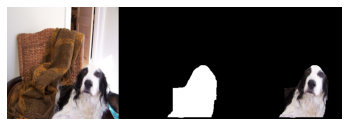

In [ ]:
plt.axis('off')
img = x[0]
msk = y[0,:,:,1]
# msk = y[0].squeeze()
msk = np.stack((msk,)*3, axis=-1)

plt.imshow( np.concatenate([img, msk, img*msk], axis = 1))

In [ ]:
def mean_iou_binary(y_true, y_pred):
    yt0 = y_true[:,:,:,0]
    yp0 = K.cast(y_pred[:,:,:,0] > 0.5, 'float32')
    inter = tf.count_nonzero(tf.logical_and(tf.equal(yt0, 1), tf.equal(yp0, 1)))
    union = tf.count_nonzero(tf.add(yt0, yp0))
    iou = tf.where(tf.equal(union, 0), 1., tf.cast(inter/union, 'float32'))
    return iou

In [ ]:
def mean_iou(y_true, y_pred):
  # B, H, W, 2
    yt0 = y_true[:,:,:,1]
    yp0 = tf.argmax(y_pred, axis=-1)
    yp0 = tf.dtypes.cast(yp0, tf.float32)
    # yp0 = K.cast(y_pred[:,:,:,0] > 0.5, 'float32')
    inter = tf.math.count_nonzero(tf.logical_and(tf.equal(yt0, 1), tf.equal(yp0, 1)))
    union = tf.math.count_nonzero(tf.add(yt0, yp0))
    iou = tf.where(tf.equal(union, 0), 1., tf.cast(inter/union, 'float32'))
    return iou

In [ ]:
def dice_coef(y_true, y_pred, smooth=1):
  y_pred = K.argmax(y_pred, axis=-1)
  y_true = y_true[:,:,:,1]
  
  y_true_f = K.flatten(y_true)
  y_pred_f = K.flatten(y_pred)
  y_true_f = K.cast(y_true_f, 'float32')
  y_pred_f = K.cast(y_pred_f, 'float32')
  intersection = K.sum(y_true_f * y_pred_f)
  return (2.0*intersection+smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

In [ ]:
def dice_loss(y_true, y_pred):
  smooth - 2.220446049250313e-16
  y_pred = K.argmax(y_pred, axis=-1)
  y_true = y_true[:,:,:,1]
  
  y_true_f = K.flatten(y_true)
  y_pred_f = K.flatten(y_pred)
  y_true_f = K.cast(y_true_f, 'float32')
  y_pred_f = K.cast(y_pred_f, 'float32')

  intersection = y_true_f * y_pred_f
  score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
  return 1.0 - score

def categorical_cross_dice_loss(y_true, y_pred):
  return categorical_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

In [ ]:
def conv_block(x, filters, kernel_size=3, padding='same', strides=1):
    'convolutional layer which always uses the batch normalization layer'
    conv = Conv2D(filters, kernel_size, kernel_initializer='he_normal', padding=padding, strides=strides)(x)
    conv = BatchNormalization()(conv)
    conv = Activation('relu')(conv)
    
    return conv

In [ ]:
def squeeze_and_excitation_block(x, ratio = 8):
  filters = x.shape[-1]
  init = x

  global_avg = tf.keras.layers.GlobalAveragePooling2D()(x)
  squeeze = tf.keras.layers.Reshape((1,1,filters))(global_avg)
  squeeze = tf.keras.layers.Dense(filters // ratio, activation='relu', kernel_initializer='he_normal')(squeeze)
  squeeze = tf.keras.layers.Dense(filters, activation='sigmoid')(squeeze)
  return tf.keras.layers.Multiply()([init, squeeze])

In [ ]:
def channel_attention(x):
  attention = Conv2D(1,(1,1), activation='sigmoid')(x)
  return tf.keras.layers.Multiply()([x,attention])

In [ ]:
def MNet(sz=(256,256,3)):
  
  nKernels =16
  
  x = Input(sz)
  ll1 = Conv2D(nKernels, (3,3), kernel_initializer='he_normal', activation='relu', padding='same')(x)
  ll2 = MaxPooling2D()(ll1)
  ll3 = MaxPooling2D()(ll2)
  ll4 = MaxPooling2D()(ll3)

  l12 = Conv2D(nKernels, (3,3), kernel_initializer='he_normal', activation='relu', padding='same')(ll1)
  cc1 = Concatenate()([ll1,l12])
  l13 = Conv2D(nKernels*2, (3,3), kernel_initializer='he_normal', activation='relu', padding='same')(cc1)
  l13 = squeeze_and_excitation_block(l13)
  
  l21 = MaxPooling2D()(l13)
  cc21 = Concatenate()([ll2,l21])
  l22 = Conv2D(nKernels*2, (3,3), kernel_initializer='he_normal', activation='relu', padding='same')(cc21)
  cc22 = Concatenate()([l22,l21])
  l23 = Conv2D(nKernels*3, (3,3), kernel_initializer='he_normal', activation='relu', padding='same')(cc22)
  l23 = squeeze_and_excitation_block(l23)
  
  l31 = MaxPooling2D()(l23)
  cc31 = Concatenate()([ll3,l31])
  l32 = Conv2D(nKernels*3, (3,3), kernel_initializer='he_normal', activation='relu', padding='same')(cc31)
  cc32 = Concatenate()([l32,l31])
  l33 = Conv2D(nKernels*4, (3,3), kernel_initializer='he_normal', activation='relu', padding='same')(cc32)
  l33 = squeeze_and_excitation_block(l33)

  l41 = MaxPooling2D()(l33)
  cc41 = Concatenate()([ll4,l41])
  l42 = Conv2D(nKernels*4, (3,3), kernel_initializer='he_normal', activation='relu', padding='same')(cc41)
  cc42 = Concatenate()([l42,l41])
  l43 = Conv2D(nKernels*8, (3,3), kernel_initializer='he_normal', activation='relu', padding='same')(cc42)
  l44 = Conv2D(nKernels*4, (3,3), kernel_initializer='he_normal', activation='relu', padding='same')(l43)

  l51 = UpSampling2D()(l44)
  cc51 = Concatenate()([l33,l51])
  l52 = Conv2D(nKernels*4, (3,3), kernel_initializer='he_normal', activation='relu', padding='same')(cc51)
  cc52 = Concatenate()([l52, l51])
  l53 = Conv2D(nKernels*3, (3,3), kernel_initializer='he_normal', activation='relu', padding='same')(cc51)
  l53 = squeeze_and_excitation_block(l53)

  l61 = UpSampling2D()(l53)
  cc61 = Concatenate()([l23,l61])
  l62 = Conv2D(nKernels*3, (3,3), kernel_initializer='he_normal', activation='relu', padding='same')(cc61)
  cc62 = Concatenate()([l62, l61])
  l63 = Conv2D(nKernels*2, (3,3), kernel_initializer='he_normal', activation='relu', padding='same')(cc62)
  l63 = squeeze_and_excitation_block(l63)

  l71 = UpSampling2D()(l63)
  cc71 = Concatenate()([l13,l71])
  l72 = Conv2D(nKernels*2, (3,3), kernel_initializer='he_normal', activation='relu', padding='same')(cc71)
  cc72 = Concatenate()([l72, l71])
  l73 = Conv2D(nKernels, (3,3), kernel_initializer='he_normal', activation='relu', padding='same')(cc72)
  l73 = squeeze_and_excitation_block(l73)

  rl4 = l44
  rl3 = UpSampling2D()(rl4)
  ccrl1 = Concatenate()([l53,rl3])
  rl2 = UpSampling2D()(ccrl1)
  ccrl2 = Concatenate()([l63,rl2])
  rl1 = UpSampling2D()(ccrl2)
  ccrl3 = Concatenate()([l73,rl1])
  
  last = Conv2D(2, (1,1), activation='softmax')(ccrl3)

  model = Model(inputs=[x], outputs=[last])
  model.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = [mean_iou])
  
  return model

In [ ]:
model = MNet()

In [ ]:
def build_callbacks():
        checkpointer = ModelCheckpoint(filepath='unet.h5', verbose=0, save_best_only=True, save_weights_only=True)
        callbacks = [checkpointer, PlotLearning()]
        return callbacks

# inheritance for training process plot 
class PlotLearning(keras.callbacks.Callback):

    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        #self.fig = plt.figure()
        self.logs = []
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('mean_iou'))
        self.val_acc.append(logs.get('val_mean_iou'))
        self.i += 1
        print('i=',self.i,'loss=',logs.get('loss'),'val_loss=',logs.get('val_loss'),'mean_iou=',logs.get('mean_iou'),'val_mean_iou=',logs.get('val_mean_iou'))
        
        #choose a random test image and preprocess
        path = np.random.choice(test_files)
        raw = Image.open(f'images/{path}')
        raw = np.array(raw.resize((256, 256)))/255.
        raw = raw[:,:,0:3]
        
        #predict the mask 
        pred = model.predict(np.expand_dims(raw, 0))
        
        #mask post-processing 
        msk = pred[0]
        msk = np.argmax(msk, axis=-1)
    
        # pred (B, W, H, C)
        # msk  = pred.squeeze()
        msk = np.stack((msk,)*3, axis=-1)
    
        # msk[msk >= 0.5] = 1 
        # msk[msk < 0.5] = 0 
        
        #show the mask and the segmented image 
        combined = np.concatenate([raw, msk, raw* msk], axis = 1)
        plt.axis('off')
        plt.imshow(combined)
        plt.show()

Epoch 1/30
1755/1755 [==============================] - 198s 92ms/step - loss: 0.4360 - mean_iou: 0.4372 - val_loss: 0.5128 - val_mean_iou: 0.2464
i= 1 loss= 0.43596699833869934 val_loss= 0.5128403902053833 mean_iou= 0.43715208768844604 val_mean_iou= 0.2463560700416565


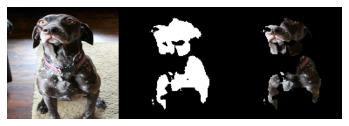

Epoch 2/30
1755/1755 [==============================] - 164s 94ms/step - loss: 0.3225 - mean_iou: 0.6124 - val_loss: 0.2800 - val_mean_iou: 0.6656
i= 2 loss= 0.3225034773349762 val_loss= 0.2800179123878479 mean_iou= 0.6123731136322021 val_mean_iou= 0.6655795574188232


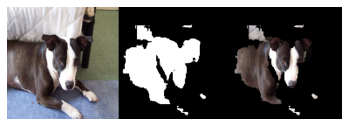

Epoch 3/30
1755/1755 [==============================] - 167s 95ms/step - loss: 0.2785 - mean_iou: 0.6626 - val_loss: 0.2486 - val_mean_iou: 0.6880
i= 3 loss= 0.27845045924186707 val_loss= 0.2486225813627243 mean_iou= 0.6626073122024536 val_mean_iou= 0.6879568696022034


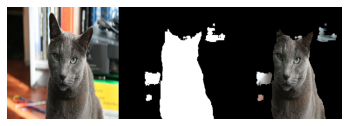

Epoch 4/30
1755/1755 [==============================] - 167s 95ms/step - loss: 0.2585 - mean_iou: 0.6921 - val_loss: 0.2190 - val_mean_iou: 0.7239
i= 4 loss= 0.2584730386734009 val_loss= 0.21902385354042053 mean_iou= 0.6921256184577942 val_mean_iou= 0.7238958477973938


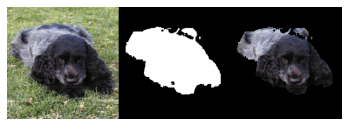

Epoch 5/30
1755/1755 [==============================] - 169s 97ms/step - loss: 0.2424 - mean_iou: 0.7070 - val_loss: 0.2095 - val_mean_iou: 0.7418
i= 5 loss= 0.2423620969057083 val_loss= 0.20947912335395813 mean_iou= 0.7069711685180664 val_mean_iou= 0.7418168783187866


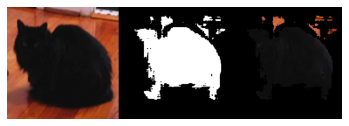

Epoch 6/30
1755/1755 [==============================] - 169s 96ms/step - loss: 0.2312 - mean_iou: 0.7210 - val_loss: 0.2314 - val_mean_iou: 0.7092
i= 6 loss= 0.23116657137870789 val_loss= 0.231438547372818 mean_iou= 0.7210410833358765 val_mean_iou= 0.7092359662055969


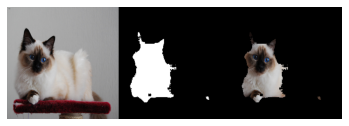

Epoch 7/30
1755/1755 [==============================] - 169s 96ms/step - loss: 0.2232 - mean_iou: 0.7326 - val_loss: 0.2430 - val_mean_iou: 0.7257
i= 7 loss= 0.22317685186862946 val_loss= 0.2430342435836792 mean_iou= 0.7325663566589355 val_mean_iou= 0.7257076501846313


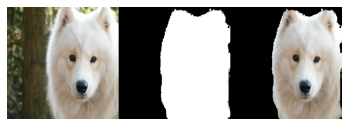

Epoch 8/30
1755/1755 [==============================] - 171s 98ms/step - loss: 0.2215 - mean_iou: 0.7361 - val_loss: 0.2069 - val_mean_iou: 0.7571
i= 8 loss= 0.22148150205612183 val_loss= 0.2069348245859146 mean_iou= 0.7360929846763611 val_mean_iou= 0.757128894329071


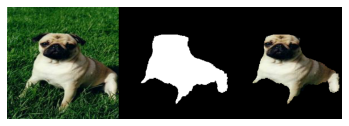

Epoch 9/30
1755/1755 [==============================] - 172s 98ms/step - loss: 0.2116 - mean_iou: 0.7417 - val_loss: 0.2074 - val_mean_iou: 0.7480
i= 9 loss= 0.2116452157497406 val_loss= 0.20742110908031464 mean_iou= 0.7417101263999939 val_mean_iou= 0.7480171918869019


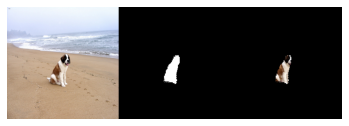

Epoch 10/30
1755/1755 [==============================] - 172s 98ms/step - loss: 0.2103 - mean_iou: 0.7450 - val_loss: 0.2176 - val_mean_iou: 0.7634
i= 10 loss= 0.21029254794120789 val_loss= 0.21764345467090607 mean_iou= 0.7450249791145325 val_mean_iou= 0.7634437680244446


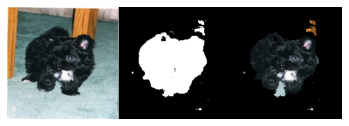

Epoch 11/30
1755/1755 [==============================] - 173s 99ms/step - loss: 0.2089 - mean_iou: 0.7513 - val_loss: 0.1947 - val_mean_iou: 0.7672
i= 11 loss= 0.20894138514995575 val_loss= 0.19472837448120117 mean_iou= 0.751258909702301 val_mean_iou= 0.7671703696250916


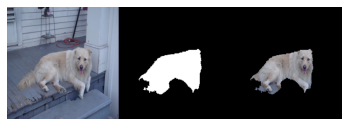

Epoch 12/30
1755/1755 [==============================] - 174s 99ms/step - loss: 0.2105 - mean_iou: 0.7448 - val_loss: 0.1859 - val_mean_iou: 0.7621
i= 12 loss= 0.21052084863185883 val_loss= 0.1859084665775299 mean_iou= 0.744779646396637 val_mean_iou= 0.7621481418609619


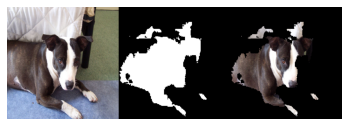

Epoch 13/30
1755/1755 [==============================] - 174s 99ms/step - loss: 0.2167 - mean_iou: 0.7491 - val_loss: 0.2024 - val_mean_iou: 0.7571
i= 13 loss= 0.21668754518032074 val_loss= 0.20236064493656158 mean_iou= 0.749149739742279 val_mean_iou= 0.7570940852165222


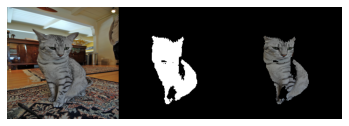

Epoch 14/30
1755/1755 [==============================] - 176s 100ms/step - loss: 0.2056 - mean_iou: 0.7555 - val_loss: 0.1911 - val_mean_iou: 0.7769
i= 14 loss= 0.2056477665901184 val_loss= 0.19107648730278015 mean_iou= 0.7555078864097595 val_mean_iou= 0.7769067883491516


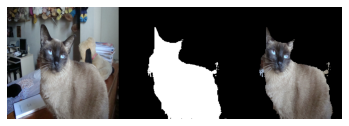

Epoch 15/30
1755/1755 [==============================] - 176s 100ms/step - loss: 0.2119 - mean_iou: 0.7522 - val_loss: 0.2568 - val_mean_iou: 0.7293
i= 15 loss= 0.21188627183437347 val_loss= 0.25680452585220337 mean_iou= 0.7522010803222656 val_mean_iou= 0.7292734384536743


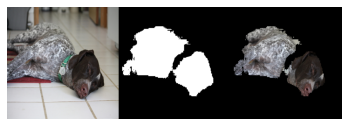

Epoch 16/30
1755/1755 [==============================] - 176s 100ms/step - loss: 0.2231 - mean_iou: 0.7485 - val_loss: 0.1845 - val_mean_iou: 0.7739
i= 16 loss= 0.2231118083000183 val_loss= 0.18452873826026917 mean_iou= 0.7485106587409973 val_mean_iou= 0.7738860845565796


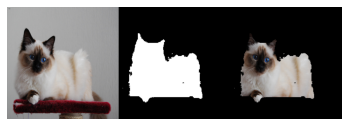

Epoch 17/30
1755/1755 [==============================] - 177s 101ms/step - loss: 0.4056 - mean_iou: 0.7266 - val_loss: 0.1874 - val_mean_iou: 0.7708
i= 17 loss= 0.4056265652179718 val_loss= 0.18735097348690033 mean_iou= 0.7266300916671753 val_mean_iou= 0.7707898616790771


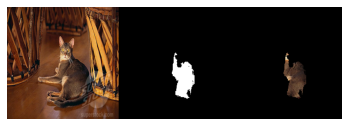

Epoch 18/30
1755/1755 [==============================] - 177s 101ms/step - loss: 0.2174 - mean_iou: 0.7480 - val_loss: 0.2789 - val_mean_iou: 0.6320
i= 18 loss= 0.21741119027137756 val_loss= 0.2789497673511505 mean_iou= 0.747975766658783 val_mean_iou= 0.6319695115089417


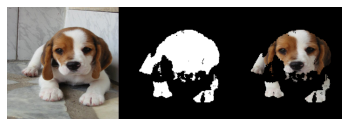

Epoch 19/30
1755/1755 [==============================] - 177s 101ms/step - loss: 0.2093 - mean_iou: 0.7543 - val_loss: 0.2162 - val_mean_iou: 0.7122
i= 19 loss= 0.20929986238479614 val_loss= 0.21620172262191772 mean_iou= 0.7543001174926758 val_mean_iou= 0.7122011780738831


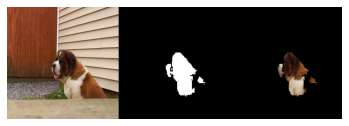

Epoch 20/30
1755/1755 [==============================] - 179s 102ms/step - loss: 0.2203 - mean_iou: 0.7501 - val_loss: 0.1860 - val_mean_iou: 0.7607
i= 20 loss= 0.22032523155212402 val_loss= 0.18595494329929352 mean_iou= 0.7500969767570496 val_mean_iou= 0.7607294917106628


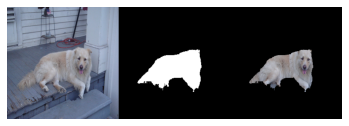

Epoch 21/30
 723/1755 [===========>..................] - ETA: 1:42 - loss: 0.2044 - mean_iou: 0.7555

KeyboardInterrupt: ignored

In [ ]:
train_steps = len(train_files) //batch_size
test_steps = len(test_files) //batch_size
model.fit(train_generator, epochs = 30, steps_per_epoch = train_steps, validation_data = test_generator, validation_steps = test_steps, callbacks = build_callbacks(), verbose = 1)